<a href="https://colab.research.google.com/github/aryanmikaeili/ML_fall_2020/blob/master/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction to Machine Learning - Sharif University of Technology, Fall 2021

# Clustering



# Notebook Objective

Up until now, you have been introduced to and worked with Supervised learning methods. In this method of learning the goal is clear; to produce desired output, given a set of inputs. However from now on, we want to explore another method of learning, namely Unsupervised learning. this method can be categorized as follows:
1. Clustering 
2. Dimensionality reduction
3. Data density estimation
4. finding a hidden cause

In this Notebook, we want to introduce and implement Kmeans algorithm. A simple and effective algorithm for clustering data.

In this notebook, we will:
1. review the Kmeans algorithm
2. implement the Kmeans algorithm
3. learn how to set k parameter
4. use Kmeans for image segmentation

# Review

As you recall, In Kmeans our goal is to divide a set of datapoints into __k__ clusters. To do so, we define the below cost function and try to minimize it.

$$ J(X, M) = \sum_k{\sum_n{r^{k}_{n}||m_k - x_n|| ^ 2}}$$
$$s.t.  \qquad r_n^k = \{0, 1\} \qquad  \sum_k r_n^k = 1$$

In which $x_n$s are the datapoints, $m_k$s are cluster centers and $r_n^k$ is a binary variable indicating whether datapoint $x_n$ is in cluster $k$ or not. In short terms, the algorithm, wants to place each cluster, and assign each point to a cluster, in a way that the sum of distances of every datapoint to their corresponding cluster centers is minimal.

This cost function, cannot be optimized in polynomial time, so we use an algorithm which consists of two steps:
1. by fixing the centers, we assign each datapoint to the closest center.
2. by fixing the datapoint assignments, we determine the center of each cluster by averaging the datapoints assigned to each cluster.

This method does not guarantee that the cost function reaches its global minimum, However, it is easy to show that in each step the cost function decreases (if it has not yet reached a local minima).

In the next part, we will implement the Kmeans algorithm an try to address some of the technical difficulties of the algorithm.

# Implementation

Please execute the cells below to initialize the notebook's environment and generate the data we are going to work with.

In [11]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


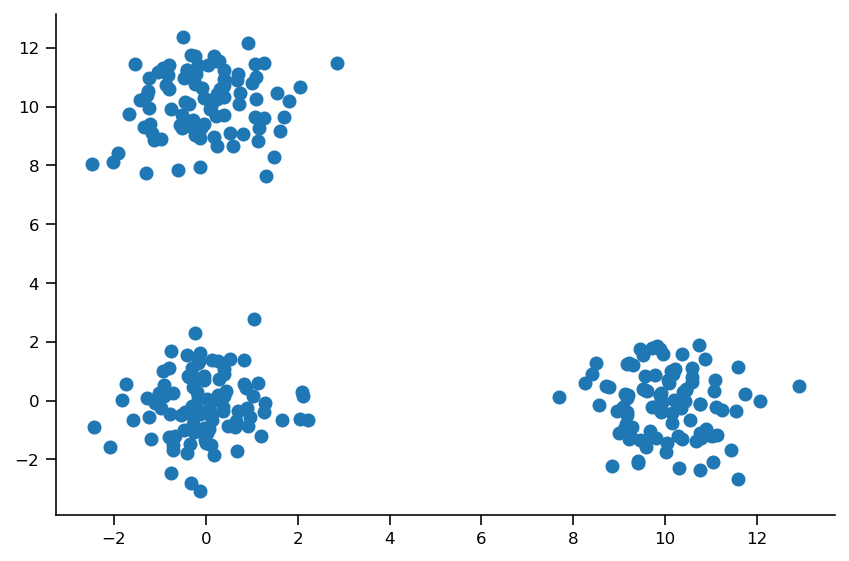

In [12]:
#@title Data generation
data = make_blobs(n_samples = [100, 100, 100], centers=[[0, 0], [0, 10], [10, 0]])[0]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

Now we want to implement the Kmeans algorithm. In order to do so we first discuss the problem of initializing the centers.

As you know, the Kmeans algorithm can easily get stuck in local minima and the final result of the algorithm, is highly dependent on the initialization of the cluster centers. As a result, we should be smart about initializing the cluster centers. There are multiple ways that we can achieve this objective:

1. randomly choose some of the datapoints
2. randomly generate the centers, from a gaussian distribution with mean and standard deviation equal to the mean and standard deviation of the dat.
3. Kmeans++ algorithm: This is a more sophisticated algorithm than the ones mentioned above. This algorithm, starts with first choosing a datapoint randomly. 
Then at the next $k - 1$ steps, in each step, we find the distance of each datapoint to the currently chosen centers and choose the next cluster center randomly from the datapoints with a probability proportional to each datapoints distance to their closest currently chosen center.


In our implementation of Kmeans, we use the Kmeans++ algorithm and random gaussian initialization.

The function below, is a function which calculates the pairwise distance of a set of points to another set of points. This will be useful both in implementing the Kmeans++ algorithm and the Kmeans algorithm itself.

In [13]:
def find_distance(x, y):

  """ please do not edit this function """

  ##################################Inputs##################################
  # x : (N1 * f) ndarray
  # y : (N2 * f) ndarray
  ##########################################################################

  ##################################Outputs##################################
  #o:  (N1 * N2) ndarray , o[i, j] is the distance of x[i] and y[j] squared
  ##########################################################################

  k = y.shape[0]
  data_size = x.shape[0]

  x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), k, axis = 1)
  y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), data_size, axis = 0)
  x_y_inner = np.matmul(x, y.T)

  o = x_norm + y_norm - 2 * x_y_inner
  return o

In [14]:
class Kmeans:

  def __init__(self, x, k, max_iters = 1000):
    self.x = x
    self.data_size = x.shape[0]
    self.feature_size = x.shape[1]
    self.k = k
    self.max_iters = max_iters

    self.centers = np.zeros((k, x.shape[1]))
  
    self.predictions = np.zeros(self.data_size)



  def Kmeans_plus_plus(self):
    centers = np.zeros((self.k, self.feature_size))
  
    centers[0] = random.choices(self.x)[0]

    for i in range(1, self.k):
      current_centers = centers[:i]
      data_center_dists = find_distance(self.x, current_centers)

      min_dists = data_center_dists.min(axis = 1)
      centers[i] = random.choices(self.x, weights = min_dists)[0]
    return centers

  def random_init(self):
      mean = np.mean(self.x, axis = 0)
      std = np.std(self.x, axis = 0)

      centers = np.random.randn(self.k, self.feature_size) * mean + std

      return centers


  def predict(self, init_mode = 'random'):

    if init_mode == 'random':
      self.centers = self.random_init()
    elif init_mode == 'kmeans++':
      self.centers = self.Kmeans_plus_plus()
    for i in range(self.max_iters):
      data_center_dists = find_distance(self.x, self.centers)
      self.predictions = data_center_dists.argmin(axis = 1)

      prev_centers = np.copy(self.centers)

      for j in range(self.k):
        cluster_j = self.x[self.predictions == j] 
        if len(cluster_j) > 0:
          self.centers[j] = cluster_j.mean(axis = 0)
      
      if (prev_centers == self.centers).all():
        return


  def calc_distortion(self):
    distortion = 0

    for i in range(self.k):
      cluster_x = self.x[self.predictions == i]
      cluster_center = self.centers[i]
      if len(cluster_x) > 0:
        cluster_distances = find_distance(cluster_x, np.expand_dims(cluster_center, 0))

        distortion += cluster_distances.sum()
    
    return distortion / self.data_size


      
    
        
    



      
    

    


You can now check your implementation, by clustering the data we generated before. You can run the algorithm with both of the initialization methods and see how the result changes.


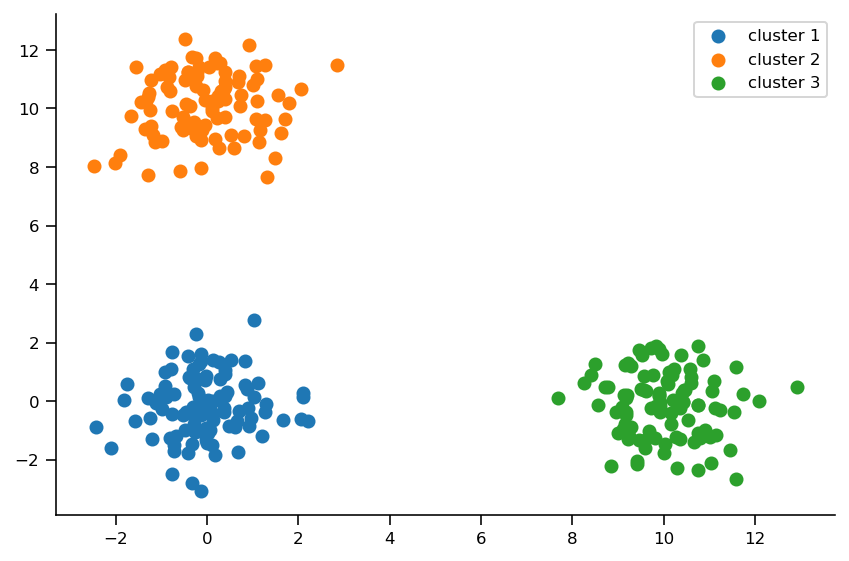

In [17]:
model = Kmeans(data, 3)
model.predict('kmeans++')
# model.predict()

plt.scatter(data[model.predictions == 0, 0], data[model.predictions == 0, 1])
plt.scatter(data[model.predictions == 1, 0], data[model.predictions == 1, 1])
plt.scatter(data[model.predictions == 2, 0], data[model.predictions == 2, 1])

plt.legend(['cluster 1', 'cluster 2', 'cluster 3'])
plt.show()

# How to choose K

choosing the number of clusters is a very important part of the Kmeans algorithm and clustering in general. 

We want to choose a k which yields the best clustering. But first we have to define what is good and what is bad in a clustering.
There are some method that measure the __goodness__ of a clustering, which we will discuss here.

The Distortion measure:

In this method we calculate a measure called __distortion__ to determine how good a clustering is. The distortion measure is calculated using the following equation:
$$D(X, M) = \sum_k{\frac{1}{C_k}\sum_n{r^k_n||m_k - x_n||^2}}$$
in which $C_k$ is the number of datapoints in cluster $k$.

As you can understand, this is simply the sum of average of distance of datapoints to their corresponding  cluster centers for each cluster. Obviously the lower the distortion measure is, the better the clustering is.

We have implemented this method in the Kmeans class in "calc_distortion" function.

In the next cell by using the slidebar, you can observe that by changing k, what happens to the distortion measure.

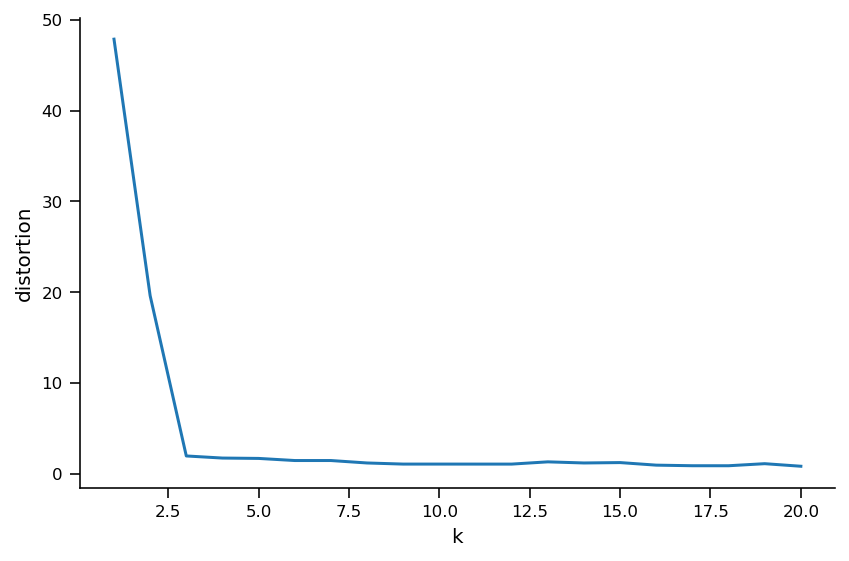

In [18]:
#@title make sure to run this cell to be able to use the widget

k = 20
distortions = np.zeros(k)
for i in range(1, k + 1):
    model = Kmeans(data, i, 1000)
    model.predict()
    distortions[i - 1] = model.calc_distortion()

plt.plot(range(1, k + 1), distortions)

plt.xlabel('k')
plt.ylabel('distortion')
plt.show()


As you can see, the distortion level, decreases sharply up until a certain k and after that, the value doesn't change very much.

Evidently, this usually happens, unless the structure of a data isn't clustered or cannot be clustered by the Kmeans algorithm. So we can choose the value of k right before the point the decrease stops. This method is called the __Elbo__ method.

# Segmentation using Kmeans

Although there are much better methods to do image segmentation, Kmeans is a simple way of dividing an image to multiple segments.

In the remaining cells, we try to use our implementation to perform segmentation on an image.

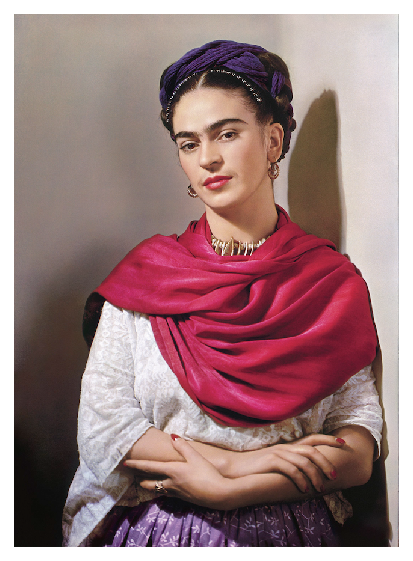

In [19]:
#@title Run this cell to load image
import cv2 as cv
import urllib

req = urllib.request.urlopen('https://wehco.media.clients.ellingtoncms.com/img/photos/2019/02/08/Frida_lead_image_t800.png?90232451fbcadccc64a17de7521d859a8f88077d')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv.imdecode(arr, -1)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# image_flat = image.reshape(-1, 3)
plt.imshow(image)
plt.axis('off')
plt.show()


clusters:  [0 1 2 3 4]
number of points:  [ 95065  65779 136591 162953 107292]


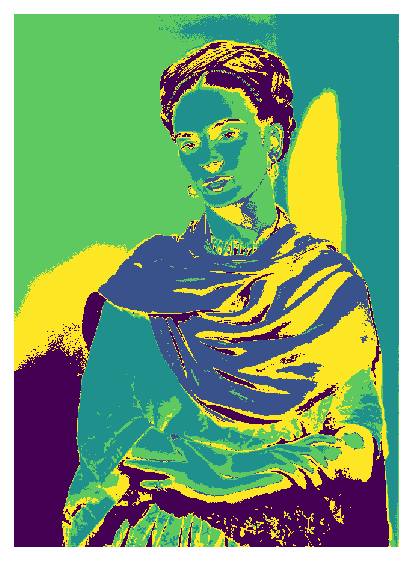

In [22]:
#@title make sure to run this cell to be able to use the widget
k = 5
image_flat = image.reshape(-1, 3)
model = Kmeans(image_flat, k, 1000)
model.predict('kmeans++')


image_clustered = model.predictions.reshape((image.shape[0], image.shape[1]))
print('clusters: ', np.unique(image_clustered, return_counts = True)[0])
print('number of points: ', np.unique(image_clustered, return_counts = True)[1])
plt.figure()
plt.imshow(image_clustered)
plt.axis('off')
plt.show();